In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn
import matplotlib.pyplot as plt

traindata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

# 查看 train data 有哪些資訊

In [2]:
print(traindata)
print()
print(traindata.info())

             Date  Open Price  Close Price  High Price  Low Price      Volume
0     02-Jan-2009      902.99       931.80      934.73     899.35  4048270080
1     05-Jan-2009      929.17       927.45      936.63     919.53  5413910016
2     06-Jan-2009      931.17       934.70      943.85     927.28  5392620032
3     07-Jan-2009      927.45       906.65      927.45     902.37  4704940032
4     08-Jan-2009      905.73       909.73      910.00     896.81  4991549952
...           ...         ...          ...         ...        ...         ...
2259  22-Dec-2017     2684.22      2683.34     2685.35    2678.13  1383888512
2260  26-Dec-2017     2679.09      2680.50     2682.74    2677.96  1103808384
2261  27-Dec-2017     2682.10      2682.62     2685.64    2678.91  1149108352
2262  28-Dec-2017     2686.10      2687.54     2687.66    2682.69  1126089856
2263  29-Dec-2017     2689.15      2673.61     2692.12    2673.61  1332374016

[2264 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>


# traindata 的前置處理，新增一些特徵

計算每日的最高價和最低價的中間值，放入 Mid Price 欄位

In [3]:
traindata['Mid Price'] = (traindata['High Price'] + traindata['Low Price']) / 2
print(traindata['Mid Price'])

0        917.040
1        928.080
2        935.565
3        914.910
4        903.405
          ...   
2259    2681.740
2260    2680.350
2261    2682.275
2262    2685.175
2263    2682.865
Name: Mid Price, Length: 2264, dtype: float64


計算每日收盤價的價差，四捨五入到小數第二位，放入 Delta Close Price 欄位

In [4]:
dcp = [0]
for i in range(1, len(traindata)):
    dcp.append(round(traindata['Close Price'][i] - traindata['Close Price'][i - 1], 2))
traindata['Delta Close Price'] = dcp
print(traindata['Delta Close Price'])

0        0.00
1       -4.35
2        7.25
3      -28.05
4        3.08
        ...  
2259    -1.23
2260    -2.84
2261     2.12
2262     4.92
2263   -13.93
Name: Delta Close Price, Length: 2264, dtype: float64


將收盤價差的漲或不變、跌分別表示為 1, -1，存入 Ups And Downs 欄位，計算結束後觀察兩者的數量，發現收盤價漲或不變的日子比跌的日子稍多

In [5]:
uad = []
ups_and_equals = 0
downs = 0
for i in range(len(traindata)):
    if traindata['Delta Close Price'][i] >= 0:
        uad.append(1)
        ups_and_equals = ups_and_equals + 1
    else:
        uad.append(-1)
        downs = downs + 1
traindata['Ups And Downs'] = uad
print(traindata['Ups And Downs'])
print()
print("Ups and Equals: ", ups_and_equals, " Downs: ", downs)

0       1
1      -1
2       1
3      -1
4       1
       ..
2259   -1
2260   -1
2261    1
2262    1
2263   -1
Name: Ups And Downs, Length: 2264, dtype: int64

Ups and Equals:  1240  Downs:  1024


將 Date 的年、月、日的資訊拆開以利於分析，並且將數值 2009..2017 改為 1..9

In [6]:
traindata['Day'] = traindata['Date'].apply(lambda x : int(x.split('-')[0]))
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
traindata['Month'] = traindata['Date'].apply(lambda x : months.get(x.split('-')[1]))
traindata['Year'] = traindata['Date'].apply(lambda x : int(x.split('-')[2]) - 2008)
print(traindata[['Date', 'Day', 'Month', 'Year']])

             Date  Day  Month  Year
0     02-Jan-2009    2      1     1
1     05-Jan-2009    5      1     1
2     06-Jan-2009    6      1     1
3     07-Jan-2009    7      1     1
4     08-Jan-2009    8      1     1
...           ...  ...    ...   ...
2259  22-Dec-2017   22     12     9
2260  26-Dec-2017   26     12     9
2261  27-Dec-2017   27     12     9
2262  28-Dec-2017   28     12     9
2263  29-Dec-2017   29     12     9

[2264 rows x 4 columns]


計算 5 日均線

In [7]:
n_days = 5
n_days_mean = []
tmp = 0
for i in range(n_days):
    tmp = 0
    for j in range(i + 1):
        tmp = tmp + traindata['Close Price'][j]
    n_days_mean.append(tmp)

for i in range(n_days, len(traindata)):
    tmp = tmp + traindata['Close Price'][i] - traindata['Close Price'][i - n_days]
    n_days_mean.append(tmp)

for i in range(n_days):
    n_days_mean[i] = round(n_days_mean[i] / (i + 1), 2)
for i in range(n_days, len(traindata)):
    n_days_mean[i] = round(n_days_mean[i] / n_days, 2)

n_label = str(n_days) + ' day mean'
traindata[n_label] = n_days_mean

查看前兩百日收盤價和均線的關係，藍色是收盤價，紅色是 5 日均線

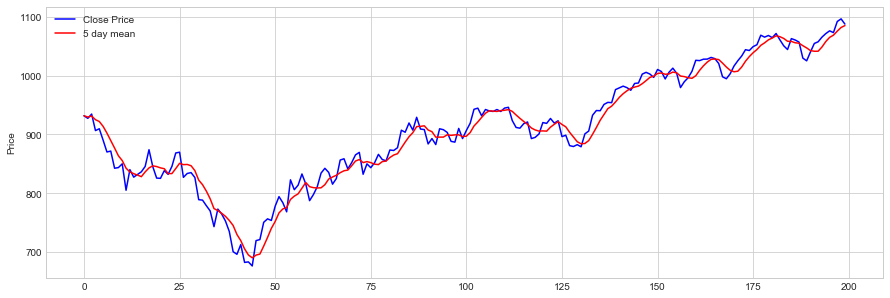

In [8]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
x = range(200)
y1 = traindata['Close Price'][0:200]
y2 = traindata[n_label][0:200]

plt.plot(x, y1, label = 'Close Price', color = 'b')
plt.plot(x, y2, label = n_label, color = 'r')
plt.ylabel('Price')
plt.legend()
plt.show()

計算 5 日均線的差

In [9]:
dndm = [0]
dndm2 = [0]
for i in range(1, len(traindata)):
    dndm2.append(round(traindata[n_label][i] - traindata[n_label][i - 1], 2))
    if traindata[n_label][i] - traindata[n_label][i - 1] >= 0:
        dndm.append(1)
    else:
        dndm.append(-1)
dn_label = 'Delta ' + n_label
dn_label2 = 'Delta ' + n_label + ' 2'

traindata[dn_label] = dndm
traindata[dn_label2] = dndm2

print(traindata[dn_label])
print(traindata[dn_label2])

0       0
1      -1
2       1
3      -1
4      -1
       ..
2259    1
2260   -1
2261    1
2262    1
2263   -1
Name: Delta 5 day mean, Length: 2264, dtype: int64
0       0.00
1      -2.18
2       1.70
3      -6.17
4      -3.08
        ... 
2259    1.51
2260   -1.93
2261    0.23
2262    1.65
2263   -2.19
Name: Delta 5 day mean 2, Length: 2264, dtype: float64


計算 2 日均線

In [10]:
n_days = 2
n_days_mean = []
tmp = 0
for i in range(n_days):
    tmp = 0
    for j in range(i + 1):
        tmp = tmp + traindata['Close Price'][j]
    n_days_mean.append(tmp)

for i in range(n_days, len(traindata)):
    tmp = tmp + traindata['Close Price'][i] - traindata['Close Price'][i - n_days]
    n_days_mean.append(tmp)

for i in range(n_days):
    n_days_mean[i] = round(n_days_mean[i] / (i + 1), 2)
for i in range(n_days, len(traindata)):
    n_days_mean[i] = round(n_days_mean[i] / n_days, 2)

n_label = str(n_days) + ' day mean'
traindata[n_label] = n_days_mean

查看前兩百日收盤價和均線的關係，藍色是收盤價，紅色是 2 日均線

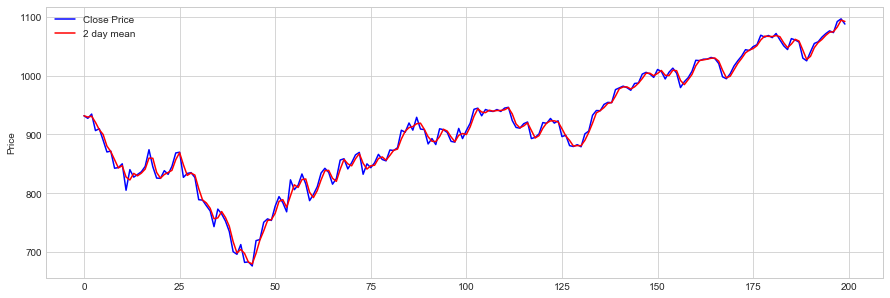

In [11]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
x = range(200)
y1 = traindata['Close Price'][0:200]
y2 = traindata[n_label][0:200]

plt.plot(x, y1, label = 'Close Price', color = 'b')
plt.plot(x, y2, label = n_label, color = 'r')
plt.ylabel('Price')
plt.legend()
plt.show()

計算 2 日均線的差

In [12]:
dndm = [0]
dndm2 = [0]
for i in range(1, len(traindata)):
    dndm2.append(round(traindata[n_label][i] - traindata[n_label][i - 1], 2))
    if traindata[n_label][i] - traindata[n_label][i - 1] >= 0:
        dndm.append(1)
    else:
        dndm.append(-1)
dn_label = 'Delta ' + n_label
dn_label2 = 'Delta ' + n_label + ' 2'
traindata[dn_label] = dndm
traindata[dn_label2] = dndm2
print(traindata[dn_label])
print(traindata[dn_label2])

0       0
1      -1
2       1
3      -1
4      -1
       ..
2259    1
2260   -1
2261   -1
2262    1
2263   -1
Name: Delta 2 day mean, Length: 2264, dtype: int64
0        0.00
1       -2.18
2        1.46
3      -10.41
4      -12.48
        ...  
2259     2.05
2260    -2.04
2261    -0.36
2262     3.52
2263    -4.50
Name: Delta 2 day mean 2, Length: 2264, dtype: float64


# 將 testdata 也做跟 traindata 一樣的前置處理

計算每日收盤價的價差，四捨五入到小是第二位，放入 Delta Close Price 欄位

In [13]:
dcp = [0]
for i in range(1, len(testdata)):
    dcp.append(round(testdata['Close Price'][i] - testdata['Close Price'][i - 1], 2))
testdata['Delta Close Price'] = dcp

將收盤價差的漲、跌、不變分別表示為 1, -1, 0，存入 Ups And Downs 欄位

In [14]:
uad = []
for i in range(len(testdata)):
    if testdata['Delta Close Price'][i] >= 0:
        uad.append(1)
    else:
        uad.append(-1)
testdata['Ups And Downs'] = uad

將 testdata 中的 Date 也拆成 Day、Month、Year

In [15]:
testdata['Day'] = testdata['Date'].apply(lambda x : int(x.split('-')[0]))
testdata['Month'] = testdata['Date'].apply(lambda x : months.get(x.split('-')[1]))
testdata['Year'] = testdata['Date'].apply(lambda x : int(x.split('-')[2]) - 2008)

計算 5 日均線

In [16]:
n_days = 5
n_days_mean = []
tmp = 0
for i in range(n_days):
    tmp = 0
    for j in range(i + 1):
        tmp = tmp + testdata['Close Price'][j]
    n_days_mean.append(tmp)

for i in range(n_days, len(testdata)):
    tmp = tmp + testdata['Close Price'][i] - testdata['Close Price'][i - n_days]
    n_days_mean.append(tmp)

for i in range(n_days):
    n_days_mean[i] = round(n_days_mean[i] / (i + 1), 2)
for i in range(n_days, len(testdata)):
    n_days_mean[i] = round(n_days_mean[i] / n_days, 2)

n_label = str(n_days) + ' day mean'
testdata[n_label] = n_days_mean

查看 2018 年收盤價和 5 日均線的關係，藍色是收盤價，紅色是均線

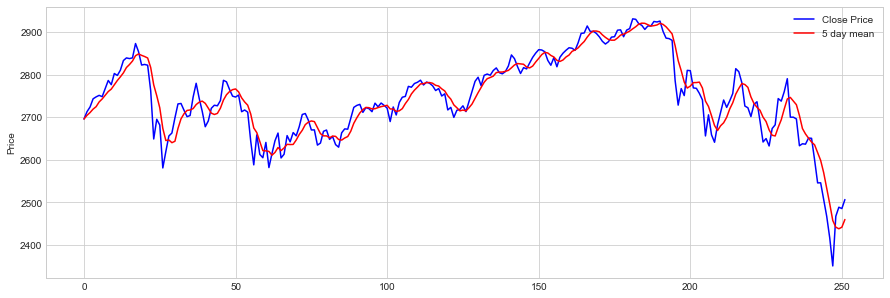

In [17]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
x = range(len(testdata))
y1 = testdata['Close Price']
y2 = testdata[n_label]

plt.plot(x, y1, label = 'Close Price', color = 'b')
plt.plot(x, y2, label = n_label, color = 'r')
plt.ylabel('Price')
plt.legend()
plt.show()

計算 5 日均線斜率，若小於0則設為 -1，大於等於 0 則設為 1

In [18]:
dndm = [0]
dndm2 = [0]
for i in range(1, len(testdata)):
    dndm2.append(round(testdata[n_label][i] - testdata[n_label][i - 1], 2))
    if testdata[n_label][i] - testdata[n_label][i - 1] >= 0:
        dndm.append(1)
    else:
        dndm.append(-1)
dn_label = 'Delta ' + n_label
dn_label2 = dn_label + ' 2'
testdata[dn_label] = dndm
testdata[dn_label2] = dndm2
print(testdata[dn_label])
print(testdata[dn_label2])

0      0
1      1
2      1
3      1
4      1
      ..
247   -1
248   -1
249   -1
250    1
251    1
Name: Delta 5 day mean, Length: 252, dtype: int64
0       0.00
1       8.63
2       6.51
3       8.05
4       5.74
       ...  
247   -38.97
248   -15.69
249    -3.63
250     3.67
251    18.04
Name: Delta 5 day mean 2, Length: 252, dtype: float64


計算 2 日均線

In [19]:
n_days = 2
n_days_mean = []
tmp = 0
for i in range(n_days):
    tmp = 0
    for j in range(i + 1):
        tmp = tmp + testdata['Close Price'][j]
    n_days_mean.append(tmp)

for i in range(n_days, len(testdata)):
    tmp = tmp + testdata['Close Price'][i] - testdata['Close Price'][i - n_days]
    n_days_mean.append(tmp)

for i in range(n_days):
    n_days_mean[i] = round(n_days_mean[i] / (i + 1), 2)
for i in range(n_days, len(testdata)):
    n_days_mean[i] = round(n_days_mean[i] / n_days, 2)

n_label = str(n_days) + ' day mean'
testdata[n_label] = n_days_mean

查看 2018 年收盤價和 2 日均線的關係，藍色是收盤價，紅色是均線

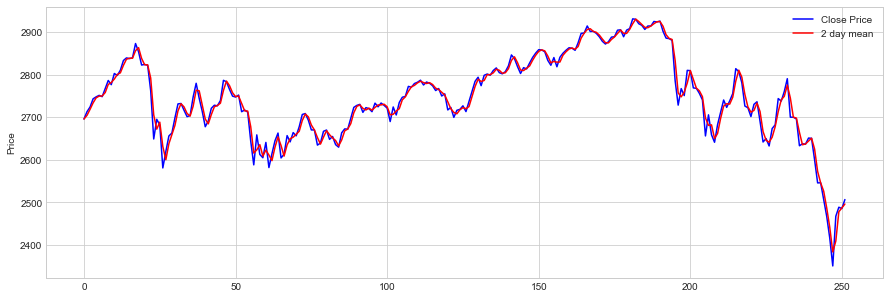

In [20]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
x = range(len(testdata))
y1 = testdata['Close Price']
y2 = testdata[n_label]

plt.plot(x, y1, label = 'Close Price', color = 'b')
plt.plot(x, y2, label = n_label, color = 'r')
plt.ylabel('Price')
plt.legend()
plt.show()

計算 5 日均線斜率，若小於0則設為 -1，大於等於 0 則設為 1

In [21]:
dndm = [0]
dndm2 = [0]
for i in range(1, len(testdata)):
    dndm2.append(round(testdata[n_label][i] - testdata[n_label][i - 1], 2))
    if testdata[n_label][i] - testdata[n_label][i - 1] >= 0:
        dndm.append(1)
    else:
        dndm.append(-1)
dn_label = 'Delta ' + n_label
dn_label2 = dn_label + ' 2'
testdata[dn_label] = dndm
testdata[dn_label2] = dndm2
print(testdata[dn_label])
print(testdata[dn_label2])

0      0
1      1
2      1
3      1
4      1
      ..
247   -1
248    1
249    1
250    1
251    1
Name: Delta 2 day mean, Length: 252, dtype: int64
0       0.00
1       8.63
2      14.08
3      15.05
4      11.86
       ...  
247   -58.16
248    25.54
249    68.86
250     9.02
251     9.01
Name: Delta 2 day mean 2, Length: 252, dtype: float64


# 2009~2017 每日收盤價的折線圖

縱坐標為 Close Price ，橫坐標為 dataframe 的每個橫列，每一年的第一天額外畫一條鉛直線標記

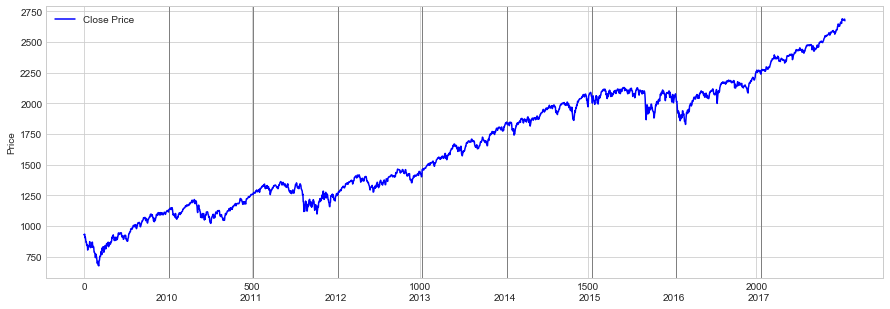

In [22]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))
x = range(len(traindata))
y1 = traindata['Close Price']

#劃出每年的分隔線
for i in range(1, len(traindata)):
    if traindata['Year'][i] != traindata['Year'][i - 1]:
        plt.axvline(x = i, linewidth = 1, color = 'gray')
        plt.text(i - 40, 400, traindata['Year'][i] + 2008)

plt.plot(x, y1, label = 'Close Price', color = 'b')
plt.ylabel('Price')
plt.legend()
plt.show()

每天收盤價跟前一天收盤價的價差分布

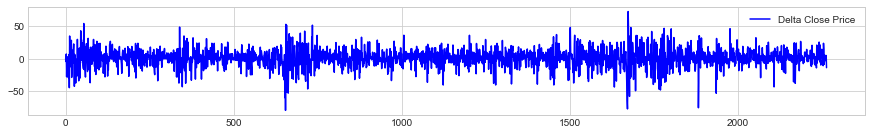

In [23]:
plt.figure(figsize=(15, 2))
y2 = traindata['Delta Close Price']
plt.plot(x, y2, label = 'Delta Close Price', color = 'b')
plt.legend()
plt.show()

觀察每日成交量，發現股價低時成交量都偏多

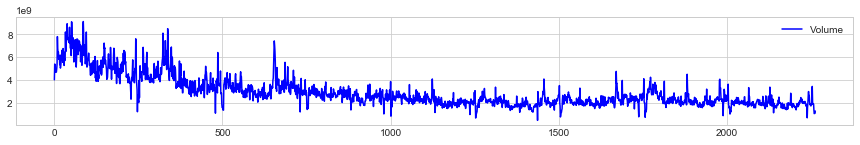

In [24]:
plt.figure(figsize=(15, 2))
y2 = traindata['Volume']
plt.plot(x, y2, label = 'Volume', color = 'b')
plt.legend()
plt.show()

# 套用模型

## Logistic Regression

使用課程投影片中的範例: [https://github.com/IKMLab/Logistic-Regression-Tutorial](https://github.com/IKMLab/Logistic-Regression-Tutorial) ，套用隨機梯度下降回歸器，參數 `loss` 設為 `log` 得到一個 logistic regression 的梯度下降模型。

將 traindata 套用到這個模型後，預測 testdata，也就是 2018 年的 Open Price、Close Price、High Price、Low Price、Volume。

In [25]:
from sklearn import linear_model, metrics, model_selection
import random

x_feature = ['Delta 5 day mean', 'Delta 2 day mean']

train_x = traindata[x_feature]
train_y = traindata['Ups And Downs']
model_log = linear_model.SGDClassifier(loss='log', max_iter=50, random_state = 3)
model_log.fit(train_x.iloc[0:len(train_x) - 1], train_y.iloc[1:])

test_x = testdata[x_feature]
test_y = testdata['Ups And Downs']

print("test data score: ", model_log.score(test_x.iloc[0:len(test_x) - 1], test_y[1:]))
test_pred = model_log.predict(test_x.iloc[0:len(train_x) - 1])
print(test_pred)

test data score:  0.549800796812749
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1
 -1  1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1
  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1  1 -1
  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1  1 -1
 -1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1
 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1
  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1]


以分布圖觀察預測結果

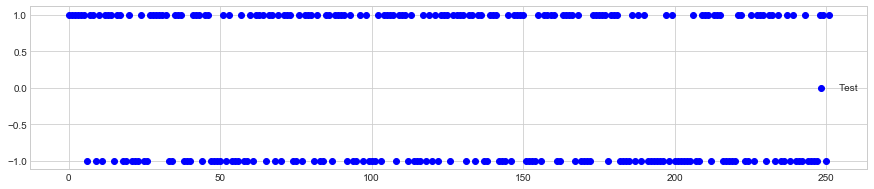

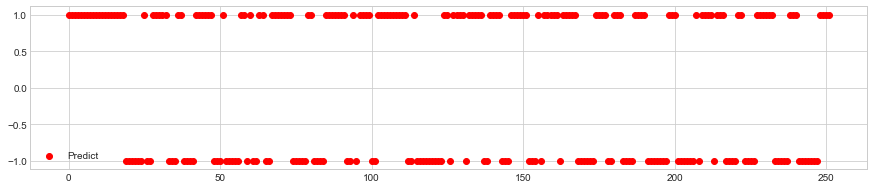

In [26]:
x = range(len(testdata))
y1 = testdata['Ups And Downs']
y2 = test_pred

plt.figure(figsize=(15,3))
plt.scatter(range(len(testdata)), y1, label = 'Test', color = 'b')
plt.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(range(len(test_pred)), y2, label = 'Predict', color = 'r')
plt.legend()
plt.show()


## Neural Network

原本使用使用課程投影片中的範例: [https://github.com/IKMLab/Feedforward-Tutorial](https://github.com/IKMLab/Feedforward-Tutorial)，無奈一直無法找出錯誤原因，所以改用sklearn的MLP

In [27]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(solver='sgd', alpha=0.0001,
                     hidden_layer_sizes=(5,3), random_state=6)

x_feature = ['Delta 5 day mean 2', 'Delta 2 day mean 2']

train_x = traindata[x_feature]
train_y = traindata['Ups And Downs']
test_x = testdata[x_feature]
test_y = testdata['Ups And Downs']

model_mlp.fit(train_x.iloc[0:len(train_x) - 1], train_y.iloc[1:])
test_pred = model_mlp.predict(test_x.iloc[0:len(train_x) - 1])
print("test data score: ", model_mlp.score(test_x.iloc[0:len(test_x) - 1], test_y[1:]))
print(test_pred)

test data score:  0.5219123505976095
[ 1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1 -1
  1  1 -1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1  1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1
 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1
 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1  1  1  1 -1 -1 -1  1  1  1 -1]


以分布圖觀察預測結果

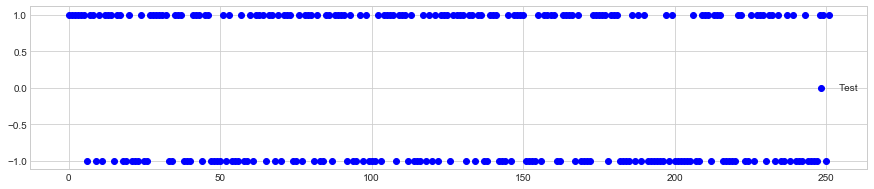

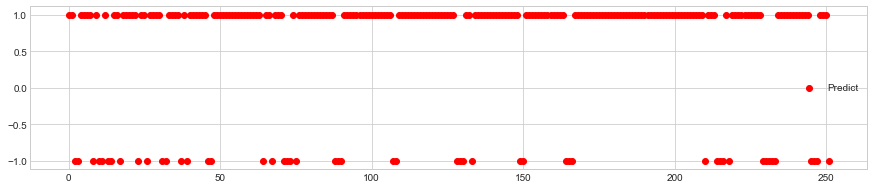

In [28]:
x = range(len(testdata))
y1 = testdata['Ups And Downs']
y2 = test_pred

plt.figure(figsize=(15,3))
plt.scatter(x, y1, label = 'Test', color = 'b')
plt.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(x, y2, label = 'Predict', color = 'r')
plt.legend()
plt.show()

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators = 500,
                             min_samples_split = 12,
                             min_samples_leaf = 1,
                             oob_score = True,
                             random_state = 3,
                             n_jobs = -1)

x_feature = ['Delta 5 day mean 2', 'Delta 2 day mean 2']

train_x = traindata[x_feature]
train_y = traindata['Ups And Downs']

test_x = testdata[x_feature]
test_y = testdata['Ups And Downs']

model_rf.fit(train_x.iloc[0:len(train_x) - 1], train_y.iloc[1:])

test_pred = model_rf.predict(test_x.iloc[0:len(test_x) - 1])
#test_acc = metrics.accuracy_score(test_y, test_pred)
print("test data score: ", model_rf.score(test_x.iloc[0:len(test_x) - 1], test_y[1:]))
#print('Testing accuracy: %s' % test_acc)
print(test_pred)

test data score:  0.4820717131474104
[-1  1  1  1  1  1 -1 -1  1  1  1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1
  1  1 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1 -1
 -1  1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1  1  1
 -1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1
  1  1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1
  1 -1 -1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1
  1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1  1 -1 -1  1  1  1  1  1 -1  1
  1  1  1  1 -1  1  1  1 -1  1  1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1
 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1 -1  1  1  1]


以分布圖觀察預測結果

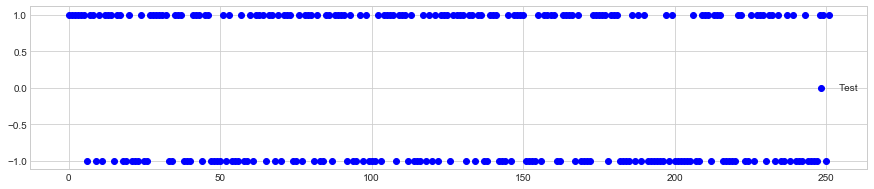

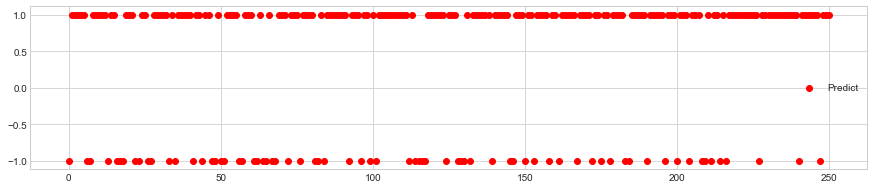

In [30]:
y1 = testdata['Ups And Downs']
y2 = test_pred

plt.figure(figsize=(15,3))
plt.scatter(range(len(testdata)), y1, label = 'Test', color = 'b')
plt.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(range(len(test_pred)), y2, label = 'Predict', color = 'r')
plt.legend()
plt.show()

## Decision Tree

多做的...

In [31]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=3)
x_feature = ['Delta 5 day mean 2', 'Delta 2 day mean 2', '5 day mean', '2 day mean']

train_x = traindata[x_feature]
train_y = traindata['Ups And Downs']

test_x = testdata[x_feature]
test_y = testdata['Ups And Downs']

model_tree.fit(train_x.iloc[0:len(train_x) - 1], train_y.iloc[1:])

test_pred = model_tree.predict(test_x.iloc[0:len(test_x) - 1])
print("test data score: ", model_tree.score(test_x.iloc[0:len(test_x) - 1], test_y[1:]))
print(test_pred)

test data score:  0.47410358565737054
[ 1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  1 -1  1 -1  1  1 -1 -1 -1
 -1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1
 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1
  1  1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
  1  1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1
  1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1
 -1  1  1  1  1  1  1  1 -1 -1 -1]


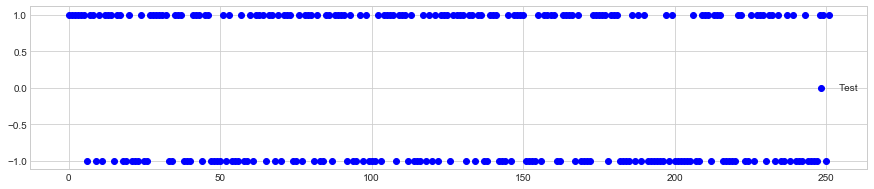

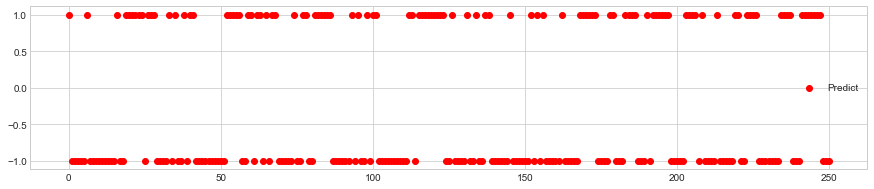

In [32]:
y1 = testdata['Ups And Downs']
y2 = test_pred

plt.figure(figsize=(15,3))
plt.scatter(range(len(testdata)), y1, label = 'Test', color = 'b')
plt.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(range(len(test_pred)), y2, label = 'Predict', color = 'r')
plt.legend()
plt.show()